# Makine Öğrenmesi: Model Parametreleri ve Matematik
Bugünkü odak: modellerin parametrelerinin neyi kontrol ettiğini matematiksel sezgi ve görsellerle pekiştirmek.
- Parametre ve hiperparametrelerin formüller içindeki rolü
- Karar sınırlarının geometriye nasıl dönüştüğü
- Küçük görsel örneklerle etkilerin hızlı gözlemlenmesi


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

np.random.seed(42)
plt.style.use('ggplot')


In [2]:
cmap_light = ListedColormap(['#FFEEEE', '#EEEEFF'])
cmap_bold = ListedColormap(['#E74C3C', '#2E86DE'])

def plot_decision_regions(model, X, y, title, ax=None, h=0.02):
    if ax is None:
        _, ax = plt.subplots()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30, alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    return ax


## 1) Lineer ve Lojistik Regresyonun Parametreleri
- Hipotez: $$ h_{\mathbf{w}}(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b $$
- Lojistik çıktı: $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$, tahmin olasılığı $p(y=1|x)=\sigma(h_w(x))$
- Log-loss: $$ J(\mathbf{w}, b) = -\frac{1}{m} \sum_{i=1}^m \big[y^{(i)} \log \hat{y}^{(i)} + (1-y^{(i)}) \log(1-\hat{y}^{(i)})\big] $$
- L2 regularizasyonu: $\lambda \lVert \mathbf{w} \rVert_2^2$ terimi büyük ağırlıkları bastırır; `C = 1/\lambda` küçüldükçe sınır daha yumuşar.
- Gradyan sezgisi: ağırlıklar, hata gradyanına ters yönde küçük adımlarla güncellenir; `learning_rate` adım büyüklüğünü belirler.


In [3]:
# Ayrık özelliklere sahip, sınıfları ayrılabilir bir veri seti
X_lin, y_lin = make_classification(
    n_samples=600, n_features=2, n_redundant=0, n_clusters_per_class=1,
    class_sep=1.2, flip_y=0.02, random_state=7
)
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(
    X_lin, y_lin, test_size=0.25, stratify=y_lin, random_state=42
)
X_lin_train.shape


(450, 2)

In [16]:
Cs = [0.000001, 10, 10000]
rows = []
models = []
for C in Cs:
    clf = LogisticRegression(C=C, solver='lbfgs')
    clf.fit(X_lin_train, y_lin_train)
    train_acc = accuracy_score(y_lin_train, clf.predict(X_lin_train))
    test_acc = accuracy_score(y_lin_test, clf.predict(X_lin_test))
    rows.append({"C": C, "w1": clf.coef_[0, 0], "w2": clf.coef_[0, 1], "bias": clf.intercept_[0],
                 "train_acc": train_acc, "test_acc": test_acc})
    models.append(clf)

pd.DataFrame(rows)


,C,w1,w2,bias,train_acc,test_acc
0,0.000001,-0.000275,0.000261,0.008899,0.502222,0.500000
1,10.000000,-4.125402,2.769016,-3.735356,0.986667,0.993333
2,10000.000000,-4.594684,3.009445,-4.415049,0.988889,0.993333


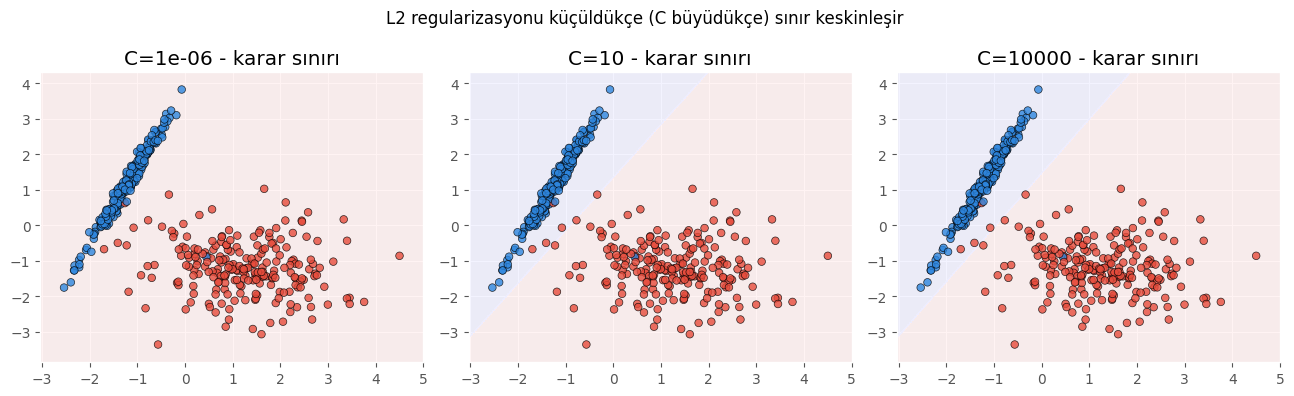

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for ax, model, C in zip(axes, models, Cs):
    plot_decision_regions(model, X_lin_train, y_lin_train, f'C={C} - karar sınırı', ax=ax)
plt.suptitle('L2 regularizasyonu küçüldükçe (C büyüdükçe) sınır keskinleşir')
plt.tight_layout()


## 2) Destek Vektör Makineleri (SVM) ve Marj
- Amaç: iki sınıf arasındaki marjini (en yakın noktaya uzaklık) maksimize etmek.
- Primal biçim: $$ \min_{w,b,\xi} \frac{1}{2}\lVert w \rVert^2 + C \sum \xi_i \quad s.t. \quad y_i (w^T x_i + b) \ge 1 - \xi_i $$
- Hinge loss: $\max(0, 1 - y (w^T x + b))$; `C` hataları ne kadar tolere edeceğimizi belirler.
- Kernel sezgisi: RBF kernel $K(x_i, x_j) = e^{-\gamma \lVert x_i - x_j \rVert^2}$; $\gamma$ büyüdükçe etki alanı daralır ve sınır kıvrılır.


,model,test_acc
0,Linear SVM,0.85
1,RBF gamma=0.5,0.91
2,RBF gamma=5,0.94


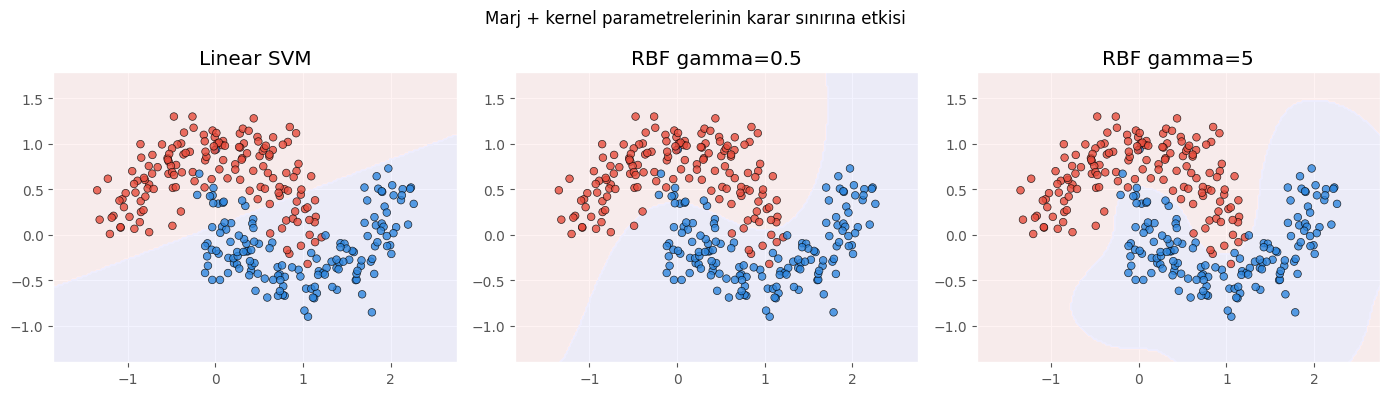

In [6]:
Xm, ym = make_moons(n_samples=400, noise=0.2, random_state=0)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.25, random_state=42, stratify=ym)
configs = [
    ('Linear SVM', SVC(kernel='linear', C=1)),
    ('RBF gamma=0.5', SVC(kernel='rbf', C=1, gamma=0.5)),
    ('RBF gamma=5', SVC(kernel='rbf', C=1, gamma=5)),
]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
scores = []
for ax, (title, model) in zip(axes, configs):
    model.fit(Xm_train, ym_train)
    plot_decision_regions(model, Xm_train, ym_train, title, ax=ax)
    scores.append((title, accuracy_score(ym_test, model.predict(Xm_test))))
plt.suptitle('Marj + kernel parametrelerinin karar sınırına etkisi')
plt.tight_layout()
pd.DataFrame(scores, columns=['model', 'test_acc'])


## 3) Karar Ağaçları ve Safsızlık (Impurity)
- Gini: $$ G(S) = 1 - \sum_k p_k^2 $$; Entropi: $$ H(S) = -\sum_k p_k \log_2 p_k $$. 
- Information Gain: $$ IG = H(parent) - \sum_j \frac{|S_j|}{|S|} H(S_j) $$
- Parametreler: `max_depth` ağaç boyunu, `min_samples_leaf` yaprakların veri ihtiyacını belirler. Çok derin ağaç yüksek varyans, sığ ağaç yüksek bias üretir.


,model,test_acc
0,"Derinlik=2, gini",0.90
1,"Derinlik=6, entropy",0.91


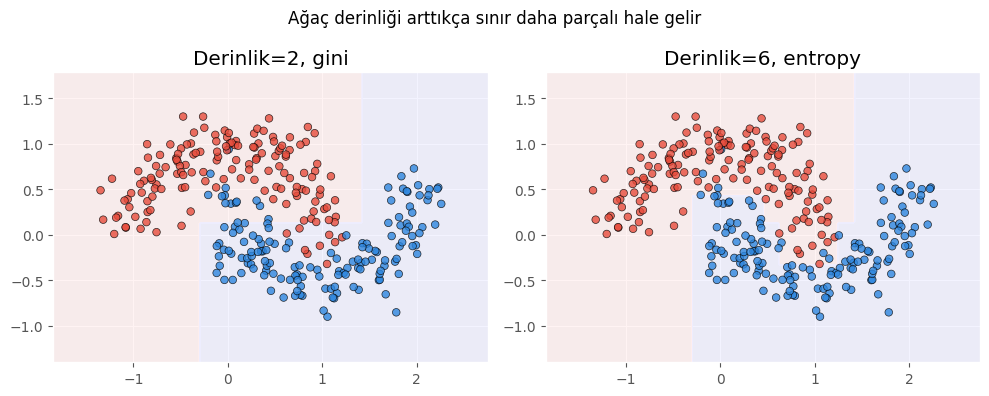

In [7]:
tree_cfgs = [
    ('Derinlik=2, gini', DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=0)),
    ('Derinlik=6, entropy', DecisionTreeClassifier(max_depth=6, criterion='entropy', min_samples_leaf=3, random_state=0)),
]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
tree_scores = []
for ax, (title, tree) in zip(axes, tree_cfgs):
    tree.fit(Xm_train, ym_train)
    plot_decision_regions(tree, Xm_train, ym_train, title, ax=ax)
    tree_scores.append((title, accuracy_score(ym_test, tree.predict(Xm_test))))
plt.suptitle('Ağaç derinliği arttıkça sınır daha parçalı hale gelir')
plt.tight_layout()
pd.DataFrame(tree_scores, columns=['model', 'test_acc'])


## 4) k-En Yakın Komşu (kNN) ve Mesafe Metrikleri
- Çekirdek fikir: karar, komşu etiketlerinin oylaması. Parametreler geometriyi doğrudan etkiler.
- Euclidyen: $$ d_2(x, x') = \sqrt{\sum_j (x_j - x'_j)^2 } $$, Manhattan: $$ d_1(x, x') = \sum_j |x_j - x'_j| $$.
- `n_neighbors` büyüdükçe sınır pürüzsüzleşir (bias ↑, varyans ↓), küçüldükçe sınır kıvrılır.
- `weights='distance'` yakın komşulara daha fazla ağırlık vererek sınırlardaki gürültüyü azaltabilir.


,model,test_acc
0,"k=3, euclid",0.93
1,"k=15, manhattan",0.93


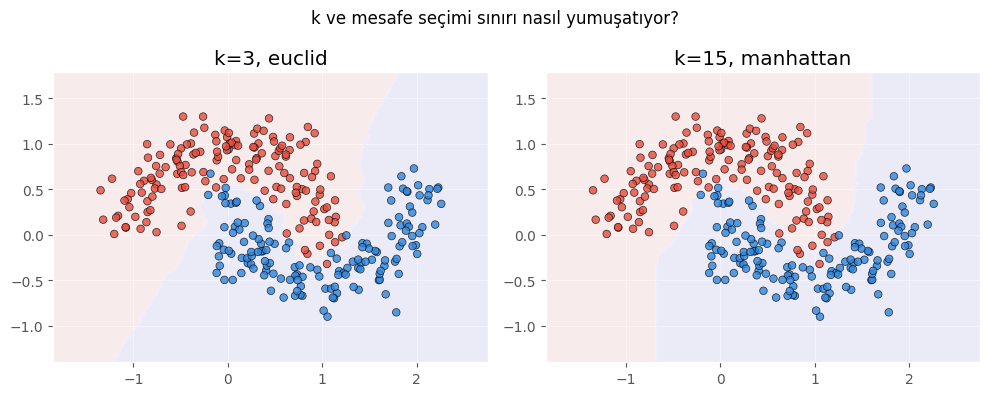

In [8]:
knn_cfgs = [
    ('k=3, euclid', KNeighborsClassifier(n_neighbors=3, p=2)),
    ('k=15, manhattan', KNeighborsClassifier(n_neighbors=15, p=1)),
]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
knn_scores = []
for ax, (title, knn) in zip(axes, knn_cfgs):
    knn.fit(Xm_train, ym_train)
    plot_decision_regions(knn, Xm_train, ym_train, title, ax=ax)
    knn_scores.append((title, accuracy_score(ym_test, knn.predict(Xm_test))))
plt.suptitle('k ve mesafe seçimi sınırı nasıl yumuşatıyor?')
plt.tight_layout()
pd.DataFrame(knn_scores, columns=['model', 'test_acc'])


## 5) Basit Bir MLP (Yapay Sinir Ağı) ve Öğrenme Dinamikleri
- İleri yayılım: $$ a^{(1)} = \sigma(W^{(1)} x + b^{(1)}), \; \hat{y} = \text{softmax}(W^{(2)} a^{(1)} + b^{(2)}) $$.
- Kayıp (binary): $$ J = -[y \log \hat{y} + (1-y) \log(1-\hat{y})] $$; gradyanlar zincir kuralı ile katmanlara yayılır.
- Parametreler:
    - `hidden_layer_sizes`: kapasiteyi belirler (fazla kapasite aşırı öğrenmeye yol açar).
    - `alpha`: L2 cezası; büyüdükçe ağırlıklar küçülür, karar sınırı yumuşar.
    - `learning_rate_init`: her adımda yapılacak güncelleme büyüklüğü.


,model,test_acc
0,Küçük kapasite,0.89
1,Daha geniş + daha fazla ceza,0.93


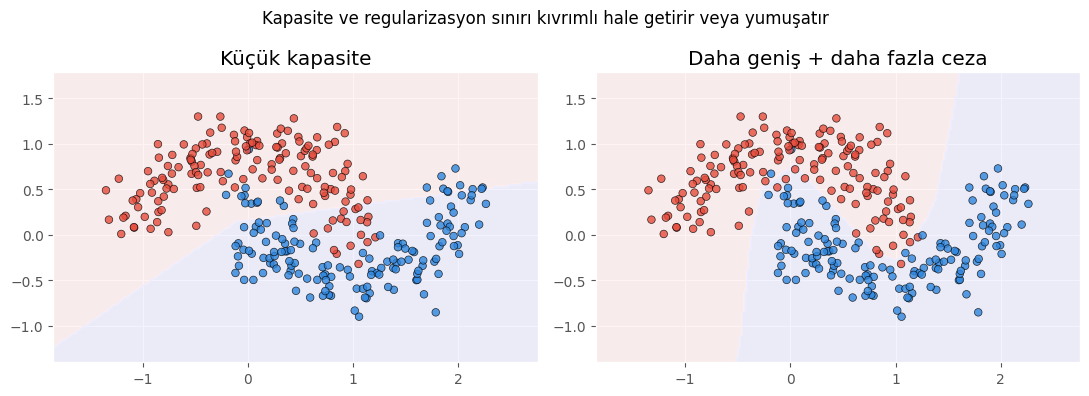

In [9]:
mlp_cfgs = [
    ('Küçük kapasite', MLPClassifier(hidden_layer_sizes=(6,), alpha=1e-4, learning_rate_init=0.05, max_iter=400, random_state=0)),
    ('Daha geniş + daha fazla ceza', MLPClassifier(hidden_layer_sizes=(20, 10), alpha=1e-2, learning_rate_init=0.05, max_iter=400, random_state=0)),
]
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
mlp_scores = []
for ax, (title, mlp) in zip(axes, mlp_cfgs):
    mlp.fit(Xm_train, ym_train)
    plot_decision_regions(mlp, Xm_train, ym_train, title, ax=ax)
    mlp_scores.append((title, accuracy_score(ym_test, mlp.predict(Xm_test))))
plt.suptitle('Kapasite ve regularizasyon sınırı kıvrımlı hale getirir veya yumuşatır')
plt.tight_layout()
pd.DataFrame(mlp_scores, columns=['model', 'test_acc'])


## 6) Mini Egzersiz Fikirleri
- `C` ve `gamma` için log-uzayda bir grid araması yapıp en iyi SVM parametrelerini bulun.
- kNN'de farklı ölçeklemeler deneyerek (standartlaştırma vs min-max) karar sınırının nasıl değiştiğini gözlemleyin.
- MLP için `learning_rate_init` değerini 0.001, 0.01, 0.1 yapıp eğitim kaybı eğrilerini karşılaştırın.
- Ağaçlarda `min_samples_leaf` değerini büyütüp model varyansını nasıl kontrol ettiğinizi gözlemleyin.
